In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time

In [8]:
import pandas as pd
coaDF = pd.read_csv('../data-processing/college-official-accounts/coa_processed.csv')
v2019DF = pd.read_csv('../data-processing/verified-2019/v2019_processed.csv')
vp2019DF = pd.read_csv('../data-processing/vp-2019/vp2019_processed.csv')
varol_realDF = pd.read_csv('../data-processing/varol-2017/varol_real_processed.csv')
varol_botDF = pd.read_csv('../data-processing/varol-2017/varol_bot_processed.csv')
varol_new_realDF = pd.read_csv('../data-processing/varol-2017/varol_real_processed_new.csv')
varol_new_botDF = pd.read_csv('../data-processing/varol-2017/varol_bot_processed_new.csv')

In [9]:
# removing some entries from data
# del coaDF['url_youtube'], v2019DF['url_youtube'], vp2019DF['url_youtube'], varol_botDF['url_youtube'], varol_realDF['url_youtube']
del coaDF['favorite'], v2019DF['favorite'], vp2019DF['favorite'], varol_realDF['favorite'], varol_botDF['favorite'], varol_new_botDF['favorite'], varol_new_realDF['favorite']
del coaDF['Unnamed: 0'], v2019DF['Unnamed: 0'], vp2019DF['Unnamed: 0'], varol_realDF['Unnamed: 0'], varol_botDF['Unnamed: 0'], varol_new_realDF['Unnamed: 0'], varol_new_botDF['Unnamed: 0']
del coaDF['favorite_over_friend'], v2019DF['favorite_over_friend'], vp2019DF['favorite_over_friend'], varol_botDF['favorite_over_friend'], varol_realDF['favorite_over_friend'], varol_new_botDF['favorite_over_friend'], varol_new_realDF['favorite_over_friend']


In [4]:
def data_split (df, split=0.7):
    train_num = int(len(df.index)*split)
    return df.iloc[:train_num,:], df.iloc[train_num+1:,:]

In [5]:
def trainRF (reals, bots, n_estimators=100):

    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    rfc = RandomForestClassifier(n_estimators=n_estimators)
    rfc = rfc.fit(data, target)
    return rfc

In [24]:
def testRF(reals, bots, RF):
    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    pred = RF.predict(data)
    return classification_report(y_true=target, y_pred=pred, target_names=['real', 'bot'])
    # print(data)
    # print(target)
    # return RF.score(data, target)

In [7]:
def testRF_ESC(reals, bots, RFs):
    data = pd.concat(reals+bots).fillna(0).to_numpy()
    target = np.array([0] * sum(len(real.index) for real in reals) + [1] * sum(len(bot.index) for bot in bots))
    totalAccNum = 0
    for i in range(data.shape[0]):
        catScore = [float(RFs[0].predict_proba([data[i]])[0][0])] + [float(RF.predict_proba([data[i]])[0][1]) for RF in RFs[1:]]
        if target[i] == 0 and catScore[0] == max(catScore) or target[i] == 1 and catScore[0] != max(catScore):
            totalAccNum += 1
        else:    
            print("Pred", i, target[i], catScore)
    return float(totalAccNum)/data.shape[0]

In [10]:
del coaDF['geo'], v2019DF['geo'],vp2019DF['geo'], varol_botDF['geo'], varol_realDF['geo'], varol_new_realDF['geo'], varol_new_botDF['geo']
del coaDF['time_zone'], v2019DF['time_zone'],vp2019DF['time_zone'], varol_botDF['time_zone'], varol_realDF['time_zone'], varol_new_realDF['time_zone'], varol_new_botDF['time_zone']

In [13]:
coaTrain, coaTest = data_split(coaDF)
v2019Train, v2019Test = data_split(v2019DF)
vp2019Train, vp2019Test = data_split(vp2019DF)
varol_realTrain, varol_realTest = data_split(varol_realDF)
varol_botTrain, varol_botTest = data_split(varol_botDF)
varol_new_realTrain, varol_new_realTest = data_split(varol_new_realDF)
varol_new_botTrain, varol_new_botTest = data_split(varol_new_botDF)

In [12]:
print(coaTrain.shape, v2019Train.shape, vp2019Train.shape, varol_botTrain.shape, varol_realTrain.shape, varol_new_botTrain.shape)

(2499, 47) (1367, 47) (477, 47) (445, 47) (862, 47) (445, 82)


In [25]:
varol_new_RF = trainRF([varol_new_realTrain], [varol_new_botTrain])
print(testRF([varol_new_realTest], [varol_new_botTest], varol_new_RF))

              precision    recall  f1-score   support

        real       0.84      0.85      0.85       369
         bot       0.71      0.69      0.70       190

    accuracy                           0.80       559
   macro avg       0.78      0.77      0.78       559
weighted avg       0.80      0.80      0.80       559



In [26]:
start_time = time.time()
importances = varol_new_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in varol_new_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


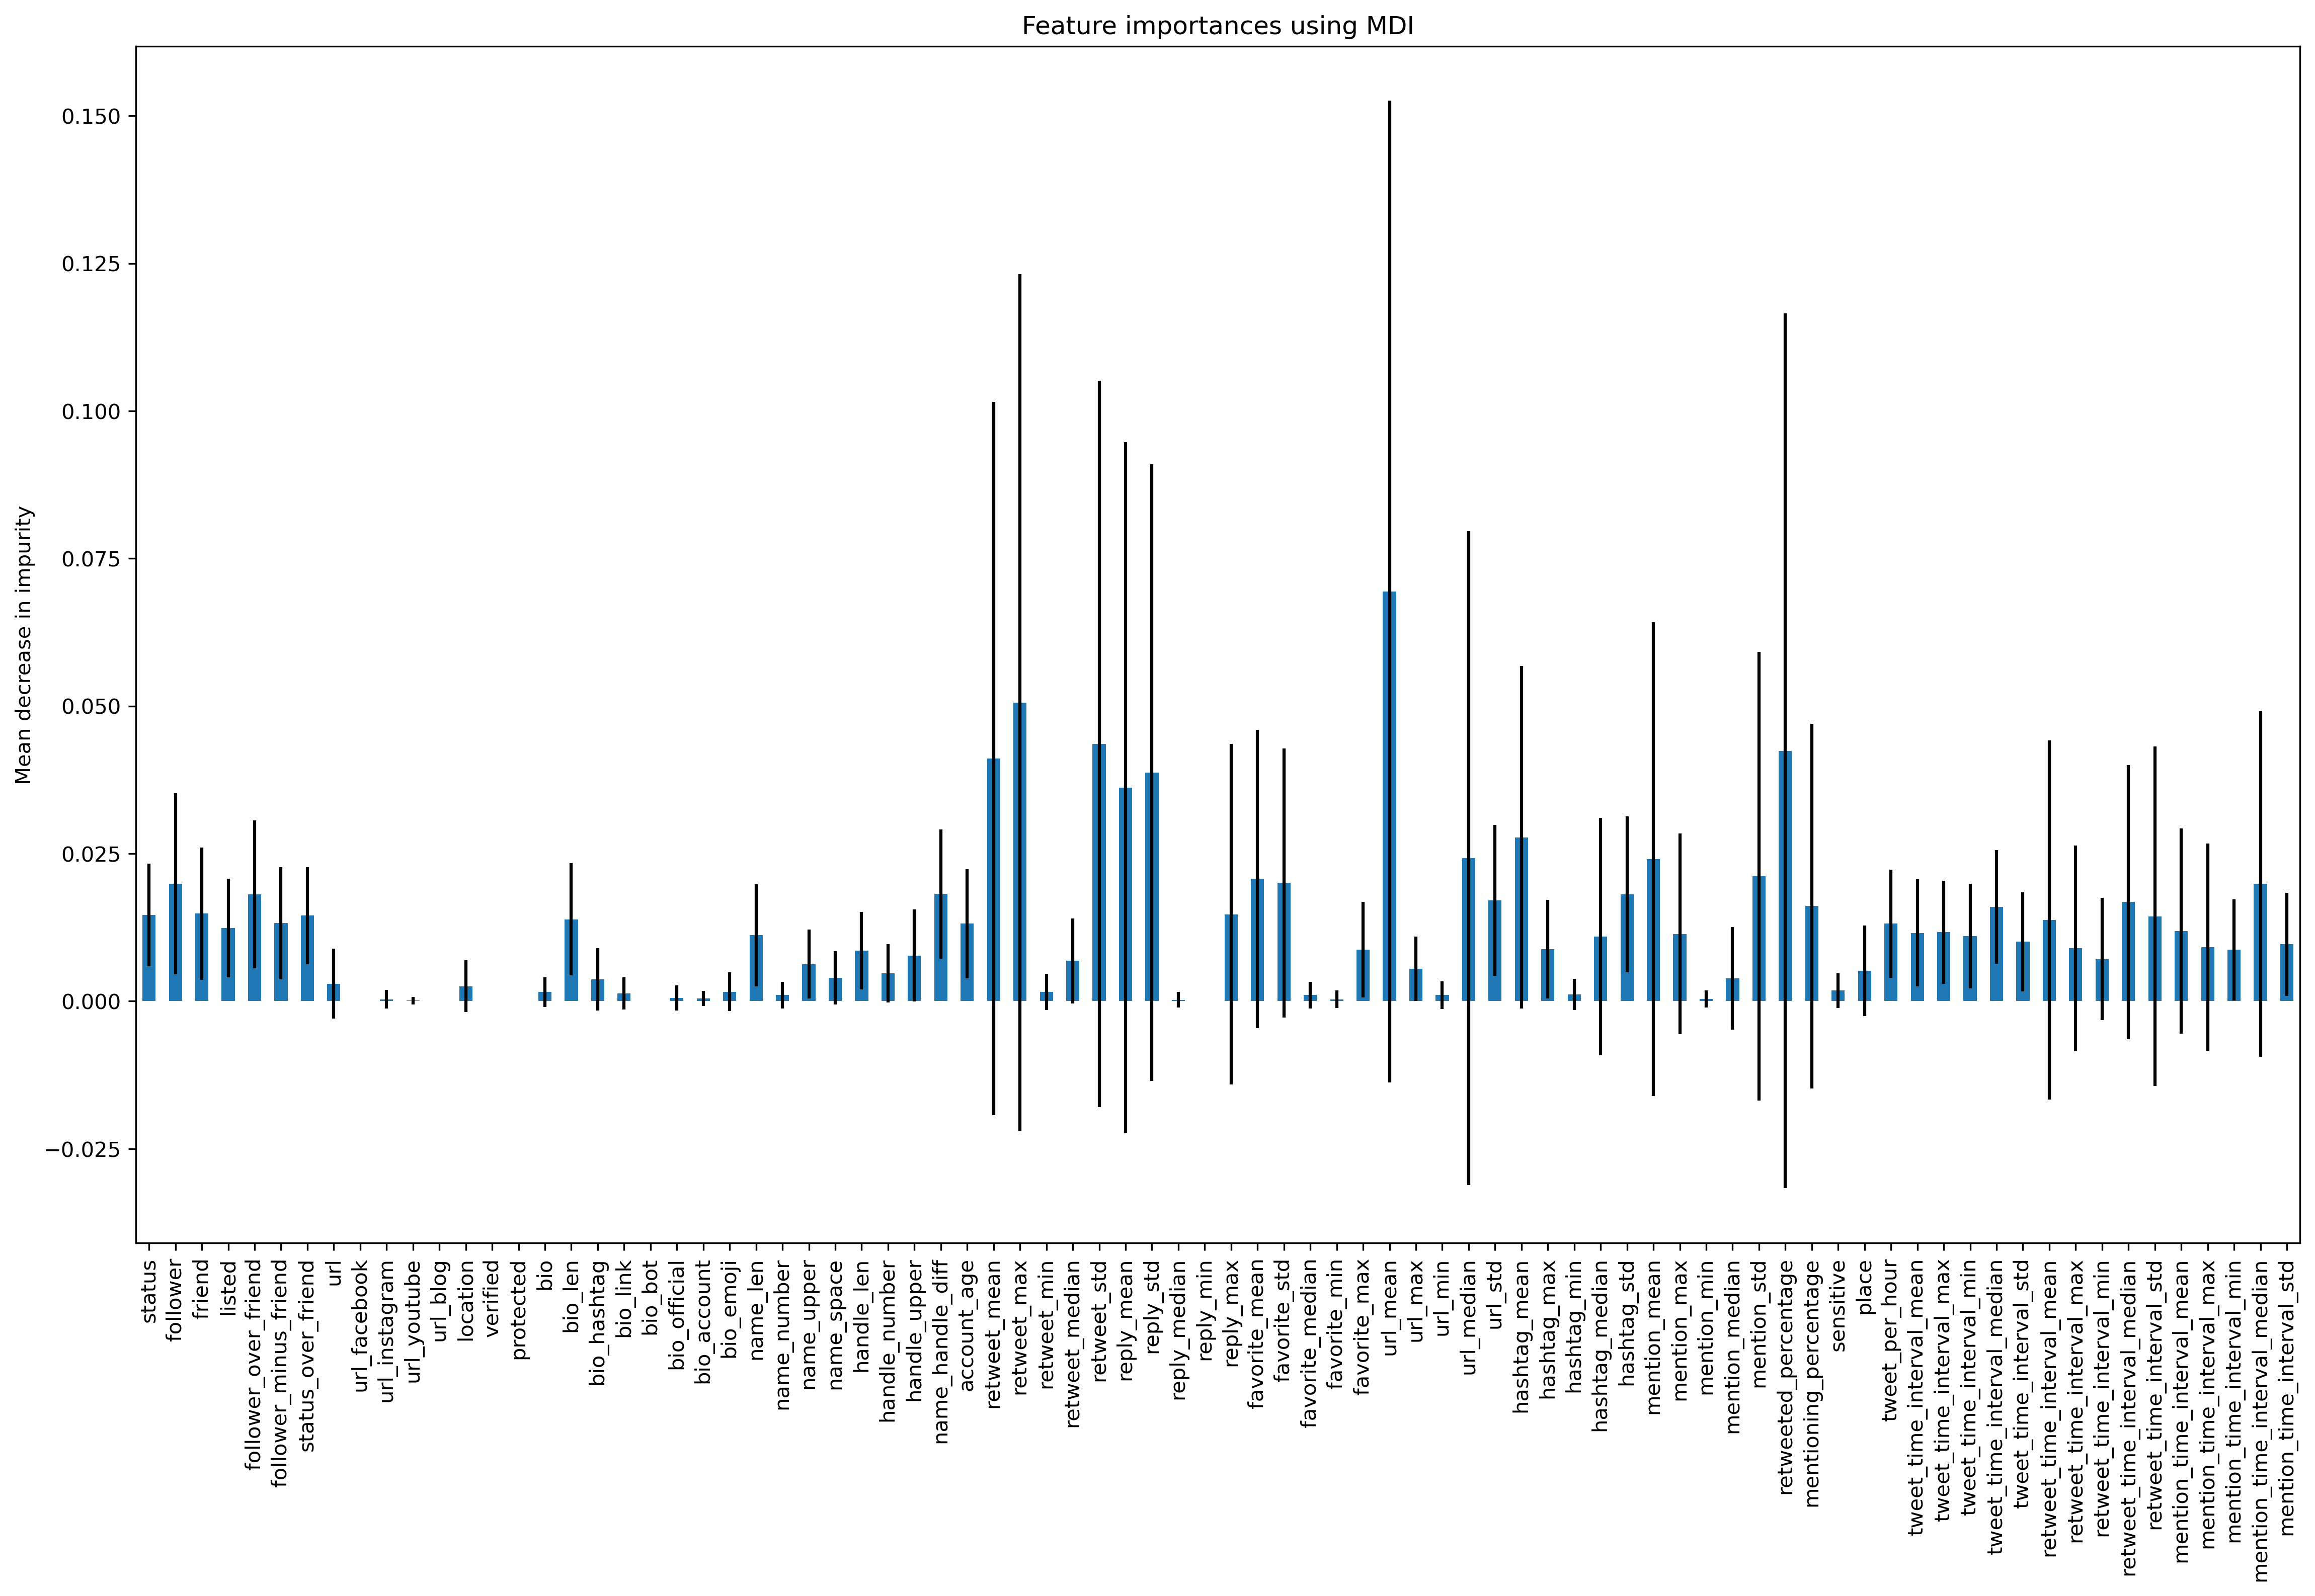

In [27]:
forest_importances = pd.Series(importances, index=varol_new_realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(300)

In [28]:
varol_small_realDF = varol_new_realDF.filter(items=['retweet_mean', 'retweet_max', 'retweet_std', 'reply_mean', 'reply_std', 'url_mean', 'retweet_percentage', 'url_median', 'mention_mean', 'hashtag_mean', 'mention_time_interval_median', 'reply_max', 'favorite_mean', 'favorite_std', 'status', 'follower', 'friend', 'follower_over_friend', 'follower_minus_friend', 'status_over_friend'], axis=1)
varol_small_botDF = varol_new_botDF.filter(items=['retweet_mean', 'retweet_max', 'retweet_std', 'reply_mean', 'reply_std', 'url_mean', 'retweet_percentage', 'url_median', 'mention_mean', 'hashtag_mean', 'mention_time_interval_median', 'reply_max', 'favorite_mean', 'favorite_std', 'status', 'follower', 'friend', 'follower_over_friend', 'follower_minus_friend', 'status_over_friend'], axis=1)

In [29]:
varol_small_realTrain, varol_small_realTest = data_split(varol_small_realDF)
varol_small_botTrain, varol_small_botTest = data_split(varol_small_botDF)

In [30]:
print(varol_small_realTrain.shape, varol_small_realTest.shape)
varol_small_RF = trainRF([varol_small_realTrain], [varol_small_botTrain])
print(testRF([varol_small_realTest], [varol_small_botTest], varol_small_RF))

(862, 19) (369, 19)
              precision    recall  f1-score   support

        real       0.84      0.83      0.84       369
         bot       0.68      0.69      0.69       190

    accuracy                           0.79       559
   macro avg       0.76      0.76      0.76       559
weighted avg       0.79      0.79      0.79       559



In [31]:
start_time = time.time()
importances = varol_small_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in varol_small_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


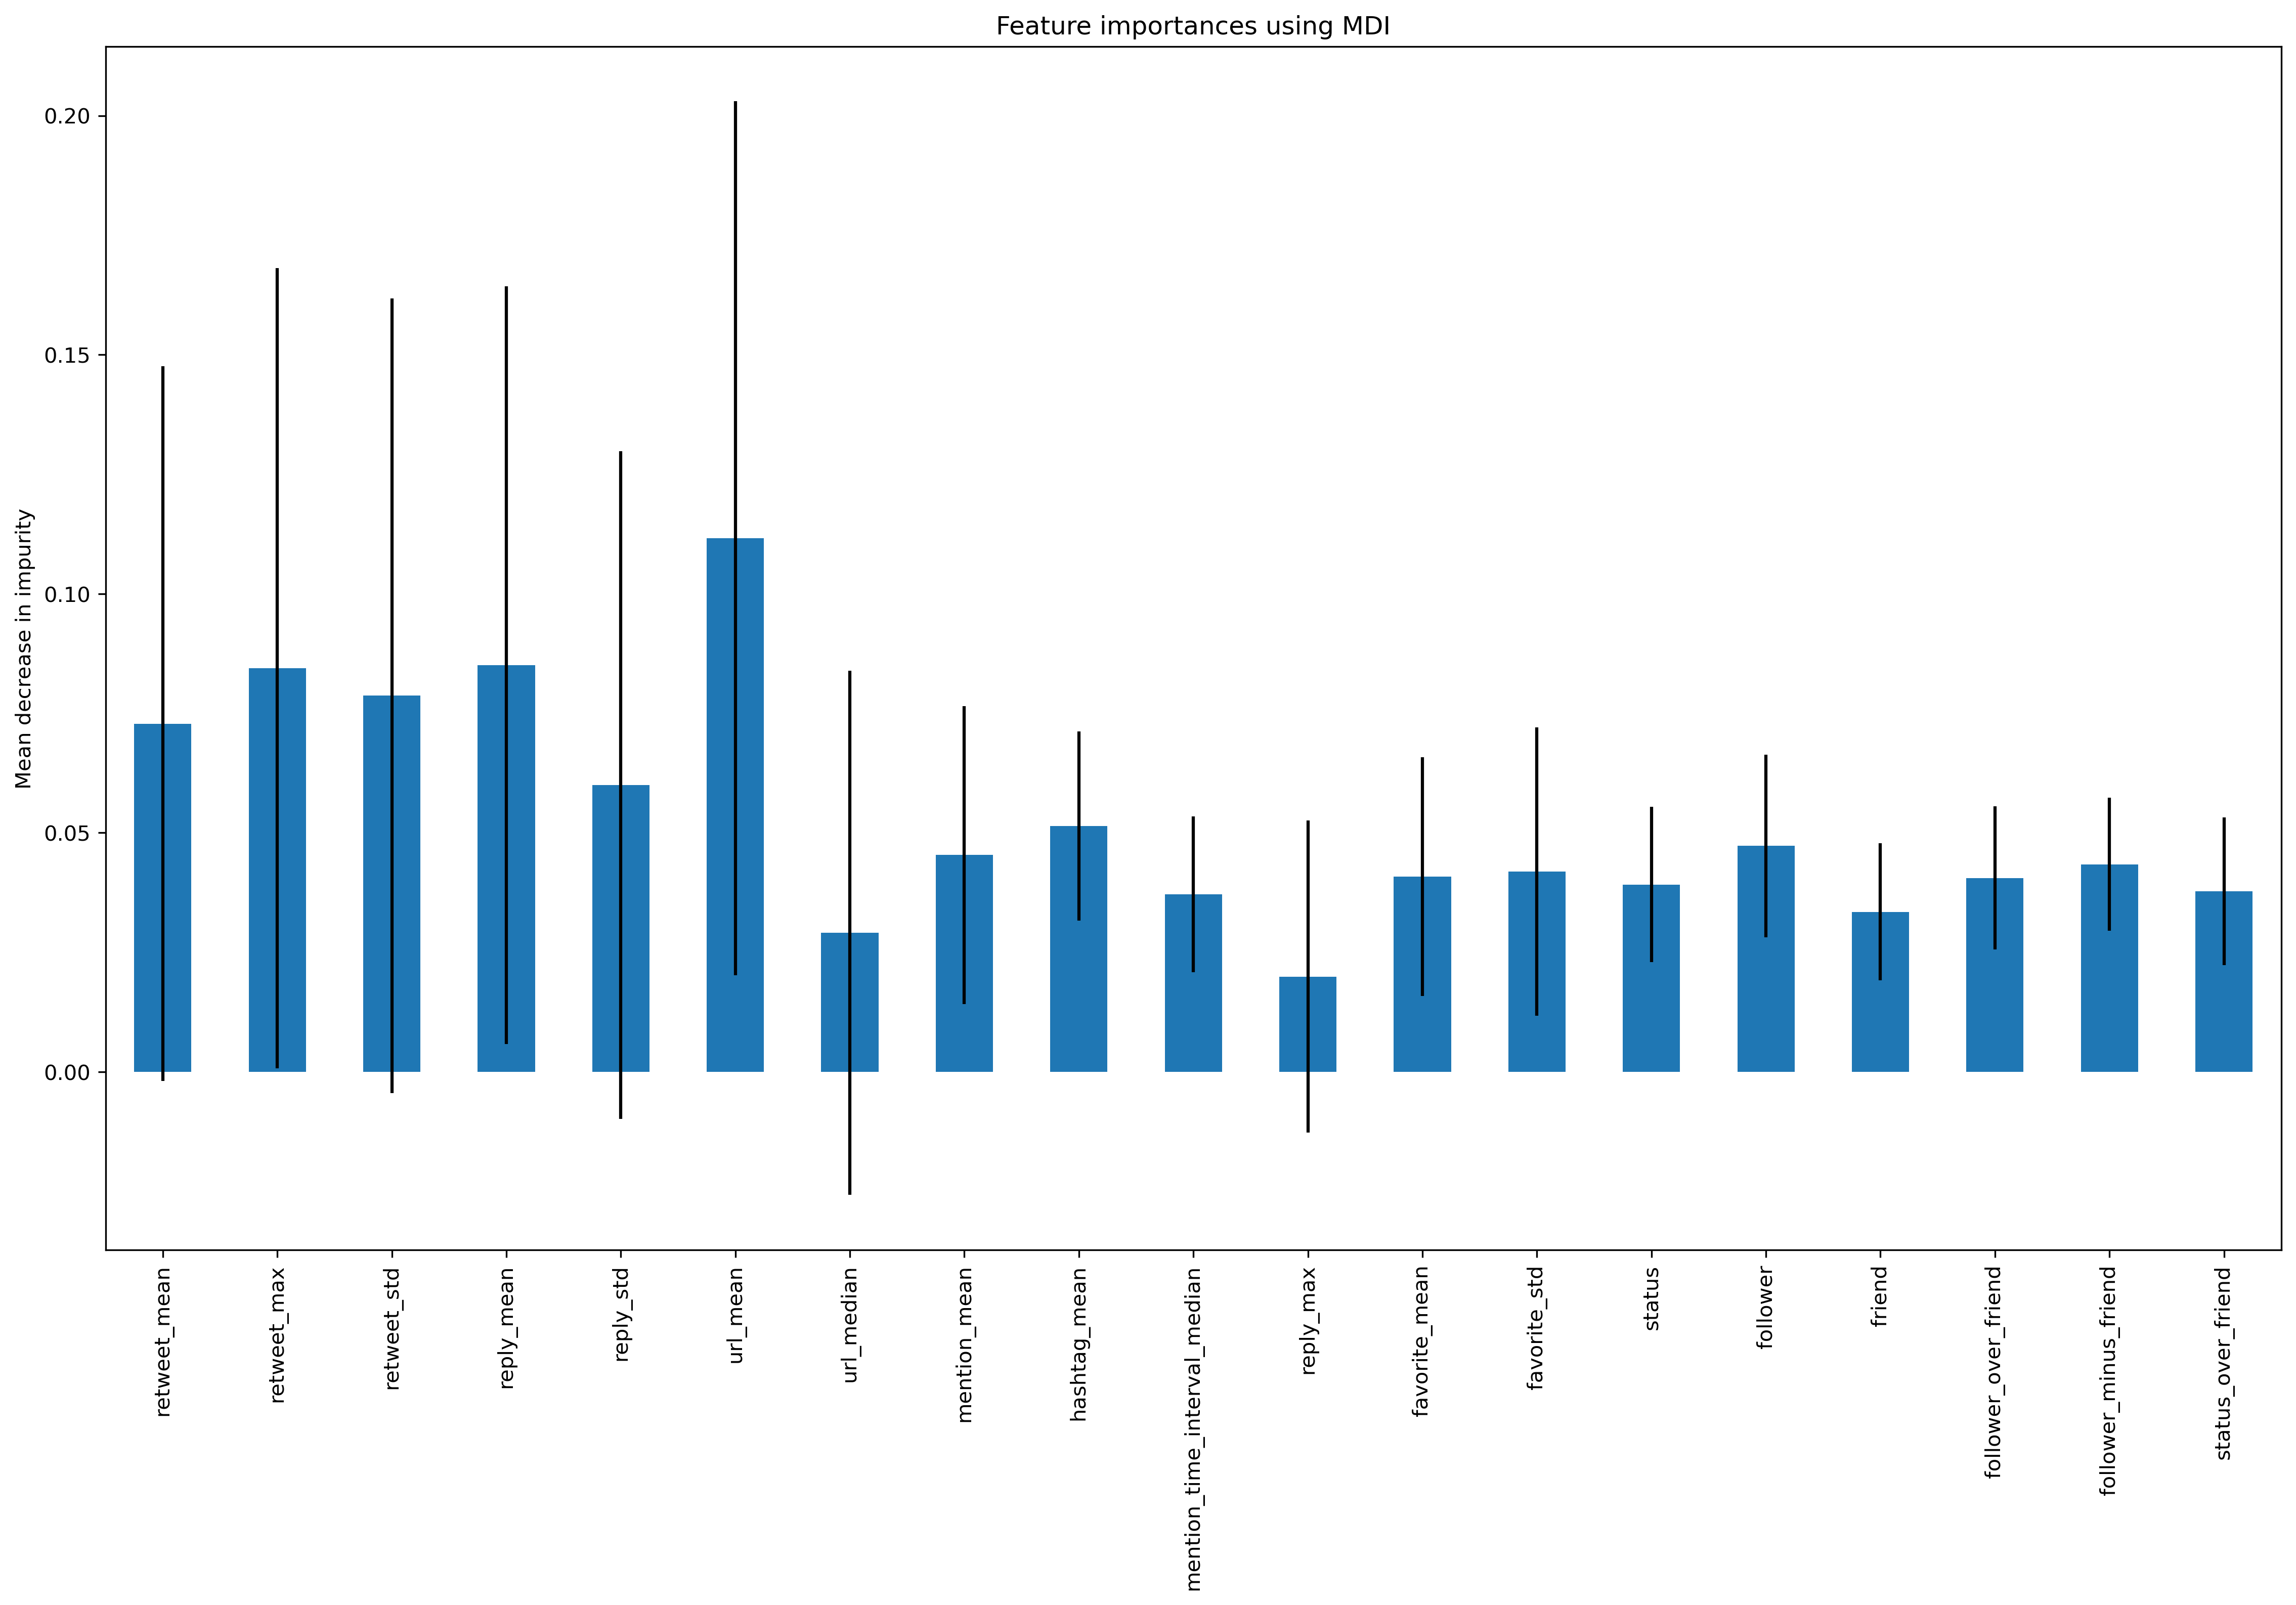

In [32]:
forest_importances = pd.Series(importances, index=varol_small_realTrain.columns.values.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(300)